### Download the data (COCO 2014)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# Move to current working directory having FastNeuralStyle.ipynb file
import os
os.chdir('/content/drive/MyDrive/Opencv/Neural Style Transfer/Fast_NST')

In [45]:
# Download COCO 2014 Train dataset
download_path = '/content/drive/MyDrive/Opencv/Neural Style Transfer/Fast_NST'
url = 'http://images.cocodataset.org/zips/train2014.zip'

In [46]:
#!pip install wget
#!pip install torch torchvision

In [47]:
# import wget
# file_name = wget.download(url, out= download_path)
# print(file_name)

In [48]:
#!unzip '/content/drive/MyDrive/Opencv/Neural Style Transfer/Fast_NST/train2014.zip' -d '/content/drive/MyDrive/Opencv/Neural Style Transfer/Fast_NST/train2014'

# Fast NST using Perceptual loss

### Fast NST Architecture

Training a style transfer model requires two networks:
- a pre-trained feature extractor: Perceptual Net (VGG19 trained on IMAGENET)
- and a transfer network : Transfer Net
- Below is VGG19 Architecture.

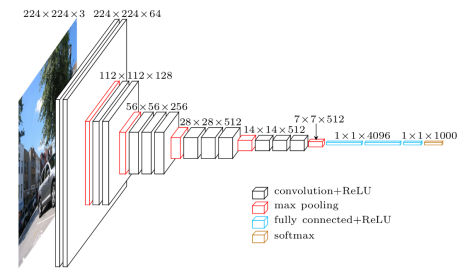

NST employs a pre-trained Convolutional Neural Network with added loss functions to transfer style from one image to another and synthesize a newly generated image with the features we want to add.

Style transfer works by activating the neurons in a particular way, such that the output image and the content image should match particularly in the content, whereas the style image and the desired output image should match in texture, and capture the same style characteristics in the activation maps.

These two objectives are combined in a single loss formula, where we can control how much we care about style reconstruction and content reconstruction.

Here are the required inputs to the model for image style transfer:

- A Content Image(Yc): an image to which we want to transfer style to
- A Style Image(Ys):  the style we want to transfer to the content image
- An Generated Input Image (Y) – the final blend of content and style image

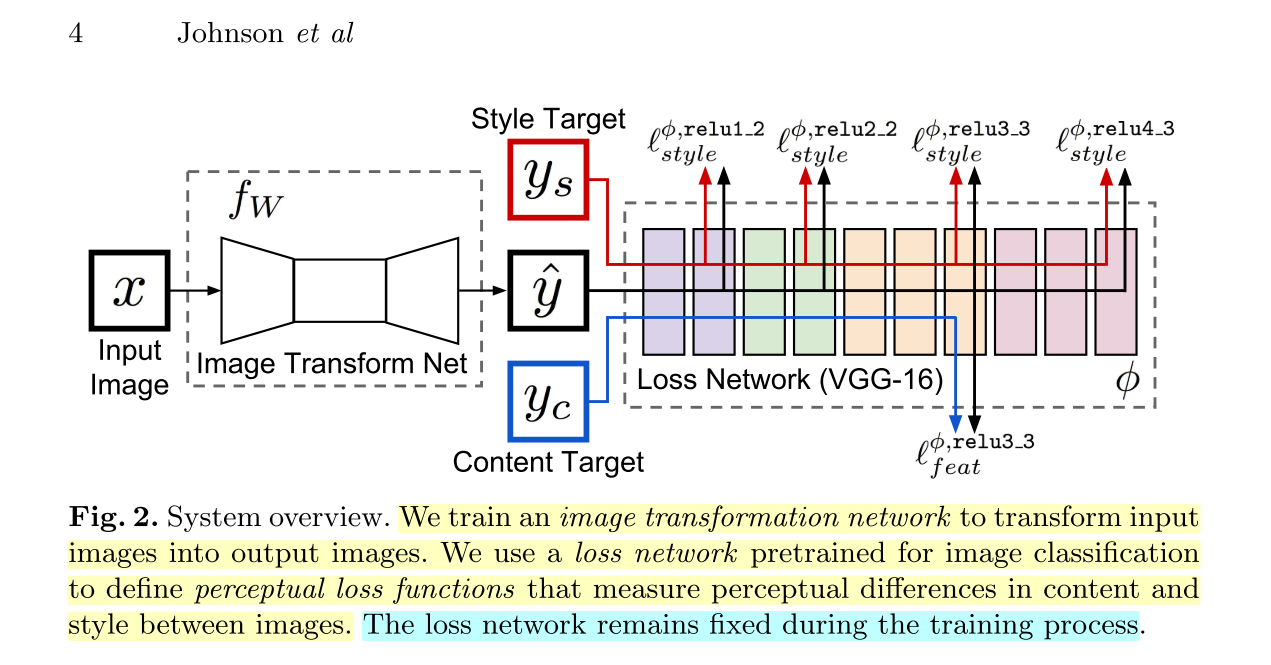

### Perceptual Loss Net

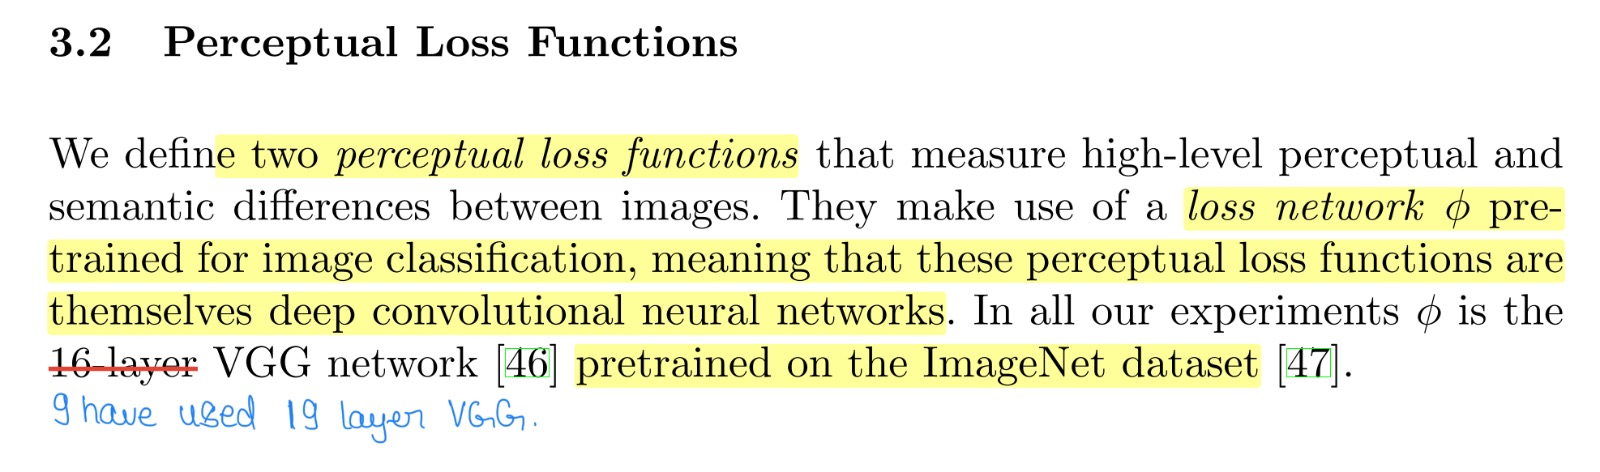

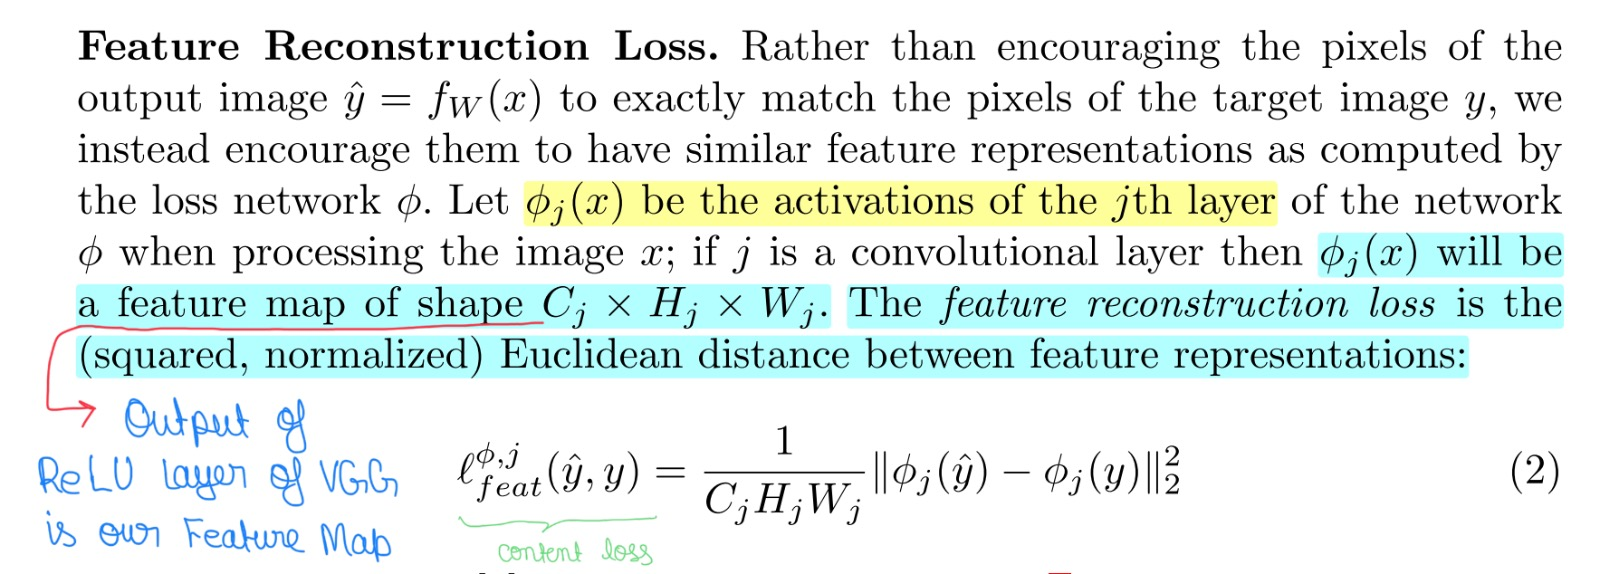

- Feature Map (Generated Image Y) = Output of Relu Layer
- Content Loss Function is MSE loss and is Implimented in Training Function  

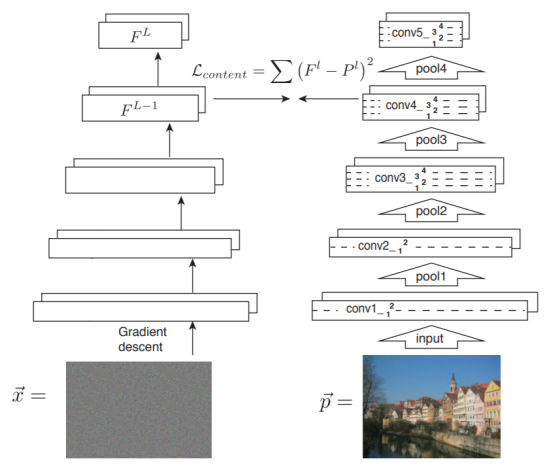

In [130]:
from collections import namedtuple
import torch
import torchvision.models.vgg as vgg
# Getting output of Relu Layers as Our Feature Map
LossOutput = namedtuple( "LossOutput", ["relu1", "relu2", "relu3", "relu4", "relu5"])

#Loss network is our Pre trained VGG model Feature generation
# Which outputs feature maps from relu layers
class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg.vgg19(pretrained=True).features
        self.layer_name_mapping = {
            '3': "relu1",
            '8': "relu2",
            '17': "relu3",
            '26': "relu4",
            '35': "relu5",
        }

    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)



```
# This is formatted as code
```

###  Transform Net

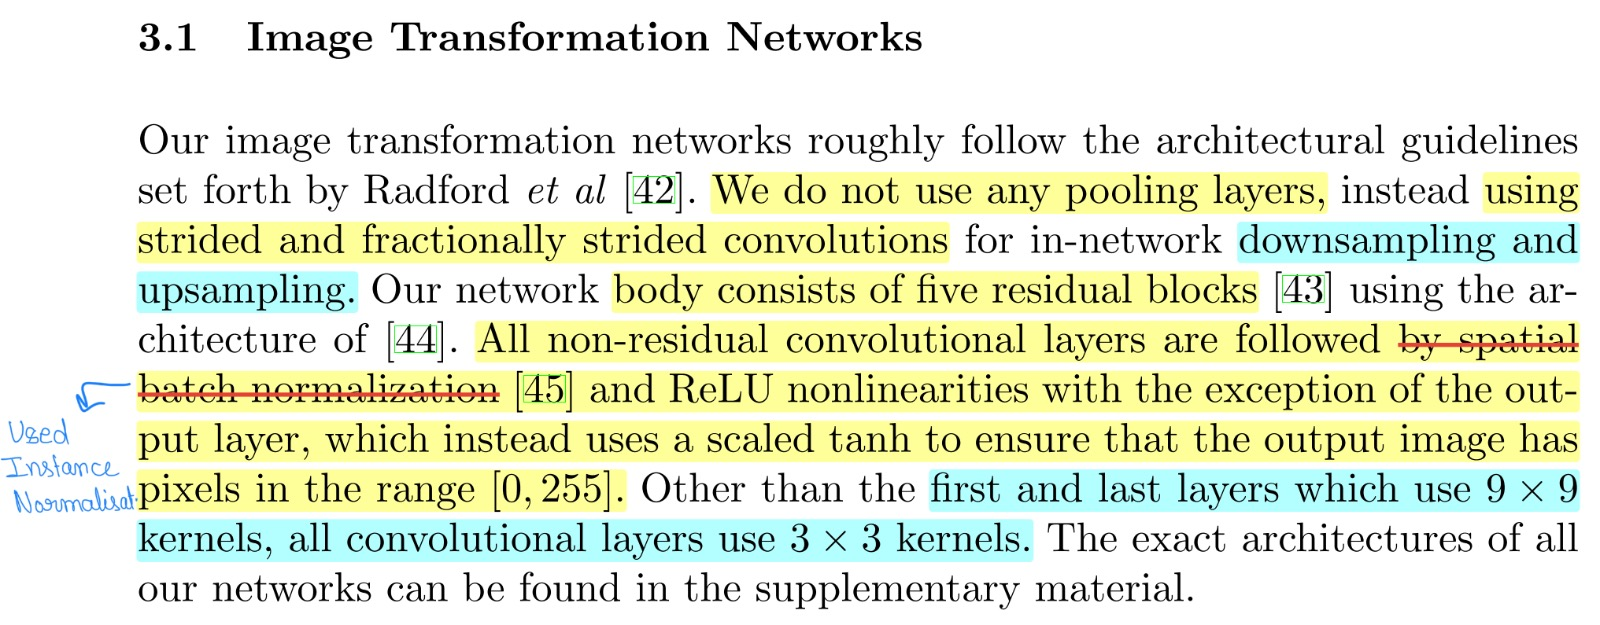

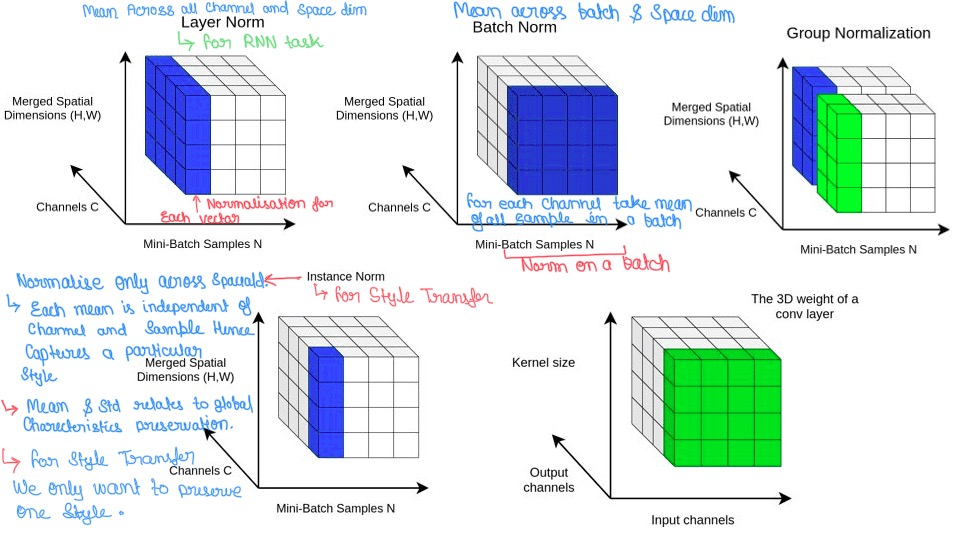

- Original Paper Used Batch Normalisation which is computationally expensive.
- I have used Instance Normalisation
- Instance normalization operates on a single sample.
-  IN doesn’t depend on the batch size, so its implementation is kept the same for both training and testing.
- The problem instance normalization tries to address is that the network should be agnostic to the contrast of the original image.


In [131]:
import torch


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()

        # Initial convolution layers or Down-sampling convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1) # first layer kernal =9*9
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)  # Instance Normalisation instead of Batch
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Convolution Layers (Reverse of downSample param)
        self.deconv1 = UpsampleConvLayer(
            128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(
            64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1) # last layer kernal =9*9
        # Non-linearities
        self.relu = torch.nn.ReLU()  # Relu Activation

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
       # A small wrapper around nn.Conv2d, so as to make the code cleaner and allow for experimentation with padding

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    # Residual Block
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(
                mode='nearest', scale_factor=upsample)
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

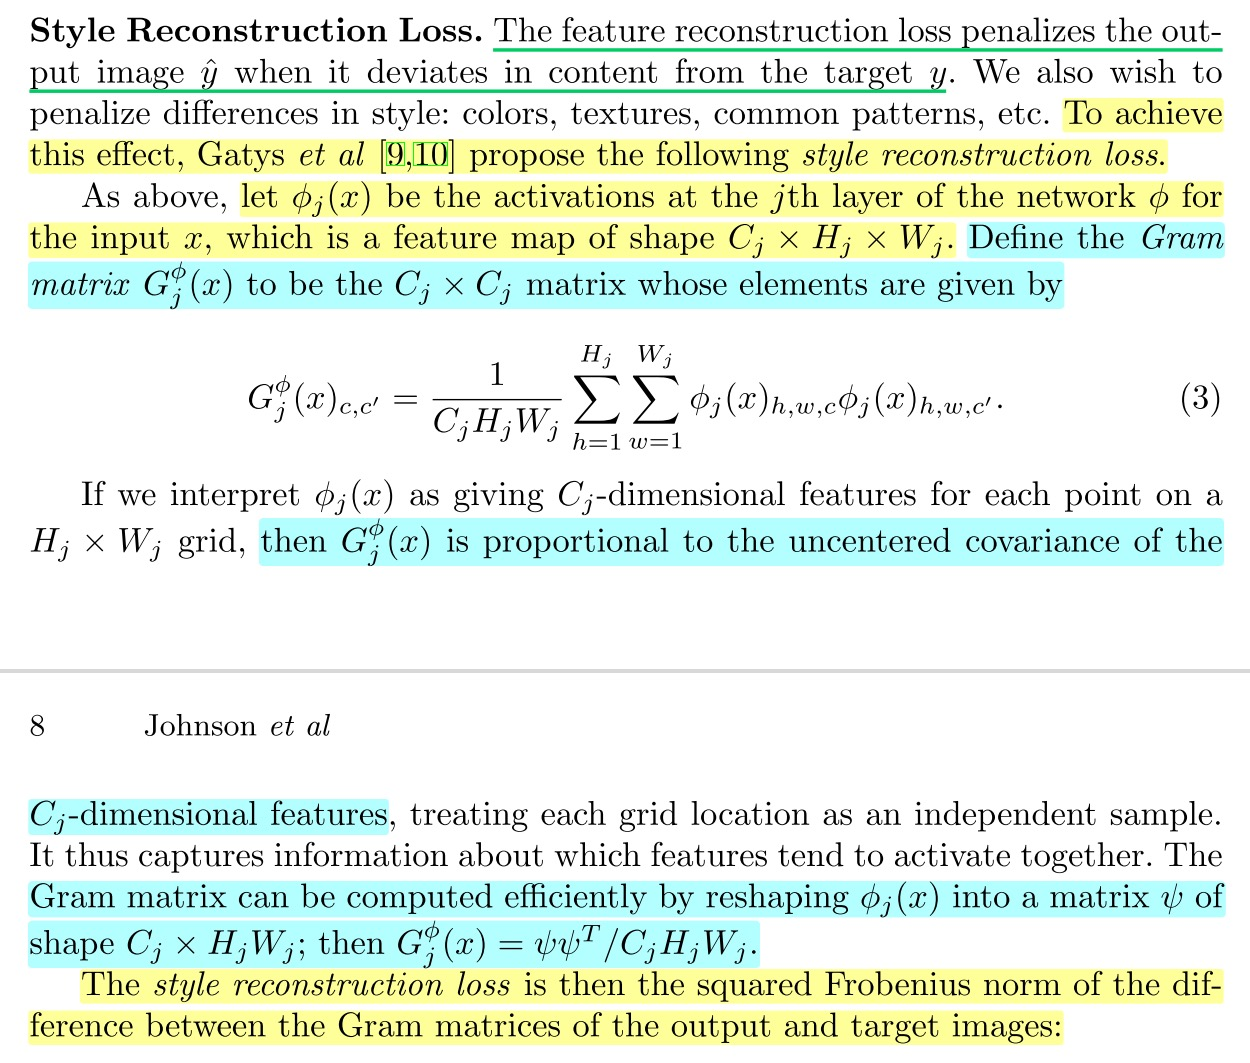

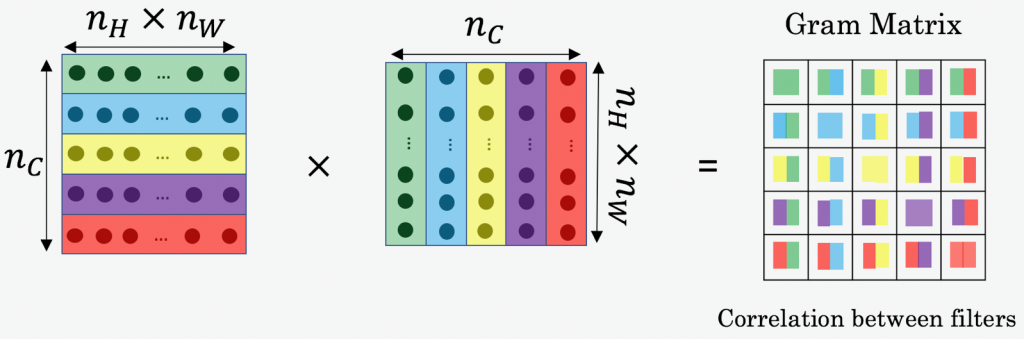

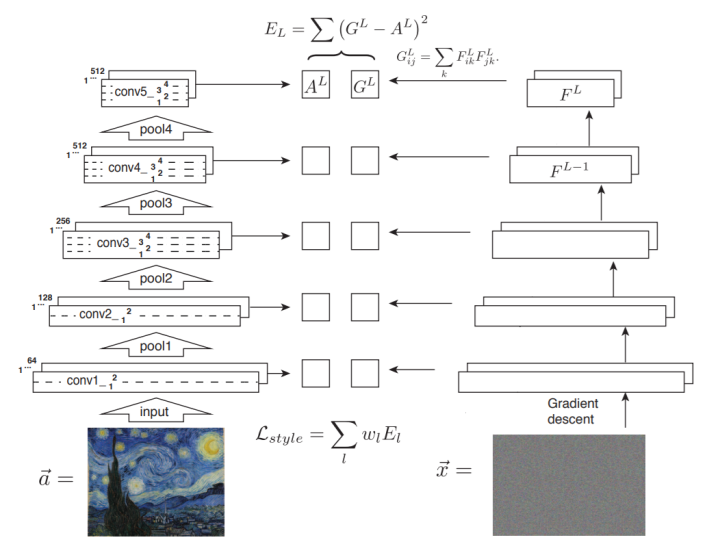

- Style loss is weighted sum of MSE loss on Gram matrix of style image and generated image for all relu layers
- Style Loss is implimented in training Code

In [132]:
#import numpy as np
from torchvision import transforms
# Feature Map (F) = (c,h,w) ->convert to (c,h*w)
# Gram matrix of F = (F*transpose of F)/(c*h*w) : matrix multiplication
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# To maintain distribution of pixel same
# Normalise it using IMAGENET mean and STD
def tensor_normalizer():
    return transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

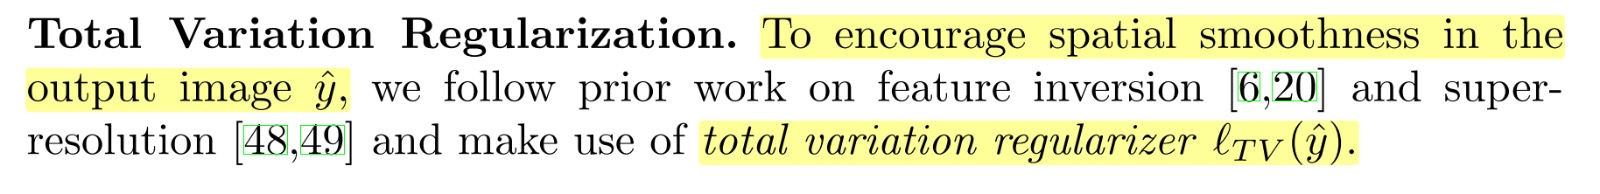

- Calculates the sum of the absolute differences between adjacent pixels along the last dimension (horizontal dimension) of the image.
- Repeat above process for verticle dimension and add both to get variational loss

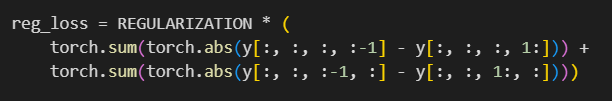

- Regularisation is implimented at training Code

### FST

In [133]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam, LBFGS
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [135]:
SEED = 1080
np.random.seed(SEED) # Numpy random numb generator seed= fixed , for reproducibility
torch.manual_seed(SEED) # pytorch random generator seed for getting same random num everytime
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED) # gpu based random generator
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 2, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [136]:
os.chdir('/content/drive/MyDrive/Opencv/Neural Style Transfer/Fast_NST')

In [137]:
cur_path = os.getcwd()
cur_path

'/content/drive/MyDrive/Opencv/Neural Style Transfer/Fast_NST'

In [138]:
## Create DataLoader for taining
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = cur_path + "/train2014"
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])

train_dataset = datasets.ImageFolder(DATASET, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [139]:
def recover_image(img):
    """
      ImageNet Mean and Std
      mean = np.array([0.485, 0.456, 0.406]) (1D array with shape(3,))
      std  = np.array([0.229, 0.224, 0.225]) (1D array with shape(3,))

      For broadcasting mean and std array for element wise multiplication with
      Output image we reshape it to match output image dimention
      Change image dimentions from (b,ch,h,w) -> (b,h,w,ch)
      Multiply and clip Image with 255 to get original pixel value.
    """

    return (
              (
              img * np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
              np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
              ).transpose(0, 2, 3, 1)*255. #
            ).clip(0, 255).astype(np.uint8)

In [181]:
# Calculate style image's Gram matrices (style representation)
# Built over feature maps as produced by the perceptual net - VGG19
STYLE_IMAGE = cur_path +  '/data/style-images/Picaso.jpg'
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        tensor_normalizer()]
    )(style_img).unsqueeze(0) # reduce batch dimension
    style_img_tensor = style_img_tensor.to(device)

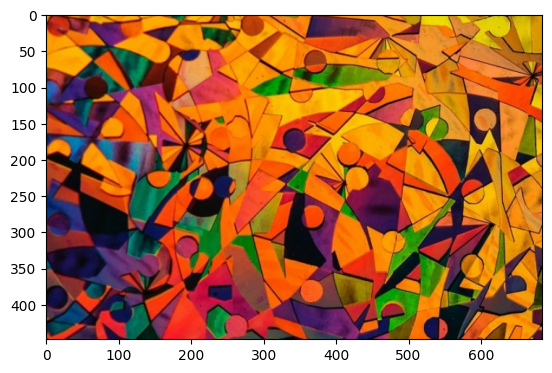

In [182]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

In [183]:
# Function for saving Generated Images while training model
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

### Train Model

In [199]:
# Create a Loss Network ie Pre trained VGG19
# Don not update Its parameter
with torch.no_grad():
    # Loss Model instance for calculating all loss
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()   # Run VGG19 in eval mode ie No weight update

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [200]:
with torch.no_grad():
    # Step1: Get feature map of Style Image from VGG Relu layers
    style_loss_features = loss_network(style_img_tensor)
    # Step 2: Calculate Gram matrix of Style_Image_features from VGG model
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [201]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [202]:
 # Step 3: Create a Tranfer Model
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [203]:
torch.set_default_tensor_type('torch.FloatTensor')

def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    while True:
        for content_img, _ in train_loader:
            count += 1
            optimizer.zero_grad()  # clear gradients for the next round

            """
              Step 1: Pass content images selected from coco dataset to transformer model
                      to get transformed stylised generated version of it.
            """
            content_img = content_img.to(device)             # x= content batch
            gen_img = transformer(content_img)     # get generated stylised image of content img

            with torch.no_grad():
                cnt_copy = content_img.detach() # create a copy of cont_img not connected with computation graph
                #Any operations performed on cont_copy won't contribute to gradient computation,

            """
            Step 2: Feed this cont_copy image and gen_img (both generated by Transform network)
                    to VGG19 model and obtain featuremap of both and calculate their Content loss.
                    I.e: Measure how much features is preserved by transformer model netween original
                    content img and its stylised version of generated image
            """
            features_gen = loss_network(gen_img)  # Loss Network is VGG19 on eval mode
            features_cont = loss_network(cnt_copy)

            with torch.no_grad():
                features_cont_copy = features_cont[2].detach()

            """
            Step 3: Calculate content loss
                    i.e  Mean Squre error between Feature map of generated image and
                    Feature map of content image.
            """
            content_loss = CONTENT_WEIGHT * mse_loss(features_gen[2], features_cont_copy)

            """
            Step 4: Calculate Total Variational Regularisation loss
                  - Regularise Generated Image from transformer model
                  - Calculates the sum of the absolute differences between adjacent pixels
                    along the last dimension (horizontal dimension) of the image.
                  - Repeat above process for verticle dimension and add both variational loss
            """
            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(gen_img[:, :, :, :-1] - gen_img[:, :, :, 1:])) +
                torch.sum(torch.abs(gen_img[:, :, :-1, :] - gen_img[:, :, 1:, :])))

            """
            Step 5: Calculate Style Reconstruction loss
                  - Get original gram matrix of Style Image for each relu layer i
                  - Get gram matrix of generated image from transformer model for each relu layer i
                  - Collect all MSE style loss for all layers i,between Original style nd generated style
            """
            style_loss = 0.
            for i, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[i] # get gram matrix of layer i of Original Style image
                gram_y = gram_matrix(features_gen[i]) # Get gram matrix of feturemap of generated image from transformer
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))

            """
            Step 6: Calculate Total loss
                  - Sum of all three loss and pass it backward to train the model
                  - Total loss = alpha*Content_loss + beta*Style_loss + gamma*Regularisation_loss
            """
            total_loss = content_loss + style_loss + reg_loss
            total_loss.backward()
            optimizer.step()

            # Logging and checkpoint creation
            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss +
                             agg_reg_loss ) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(content_img)
                save_debug_image(content_img, y.detach(),cur_path + "/Bird/{}.png".format(base_steps + count))
                transformer.train()

            if count >= steps:
                return

In [213]:
# Assign weights of each loss and optimiser
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([0.1, 1, 1, 5, 1]) * 1e5 # Style Weights of each Relu layer featuremap
# STYLE_WEIGHTS = np.array([1, 0.75,0.2, 0.2, 0.2]) * 1e6 # Style Weights of each Relu layer featuremap from NST paper
REGULARIZATION = 1e-6
LOG_INTERVAL = 100

LR = 1e-4
optimizer = Adam(transformer.parameters(), LR*0.5)

In [214]:
len(train_loader)

2524

In [215]:
train(5000,1000)

Sun Nov 12 11:52:38 2023 [100/5000] content: 21.15  style: 9.41  reg: 0.15 total: 30.708735
Sun Nov 12 11:53:01 2023 [200/5000] content: 20.89  style: 9.22  reg: 0.15 total: 30.256447
Sun Nov 12 11:53:24 2023 [300/5000] content: 20.74  style: 9.13  reg: 0.15 total: 30.016958
Sun Nov 12 11:53:47 2023 [400/5000] content: 20.78  style: 9.09  reg: 0.15 total: 30.023308
Sun Nov 12 11:54:10 2023 [500/5000] content: 20.41  style: 9.11  reg: 0.15 total: 29.667721
Sun Nov 12 11:54:33 2023 [600/5000] content: 20.39  style: 9.14  reg: 0.15 total: 29.689236
Sun Nov 12 11:54:56 2023 [700/5000] content: 20.24  style: 9.16  reg: 0.15 total: 29.554045
Sun Nov 12 11:55:19 2023 [800/5000] content: 20.07  style: 8.83  reg: 0.15 total: 29.053843
Sun Nov 12 11:55:42 2023 [900/5000] content: 19.98  style: 9.07  reg: 0.15 total: 29.209421
Sun Nov 12 11:56:05 2023 [1000/5000] content: 19.88  style: 8.70  reg: 0.16 total: 28.735979
Sun Nov 12 11:56:28 2023 [1100/5000] content: 19.96  style: 8.72  reg: 0.16 tot

KeyboardInterrupt: ignored

In [ ]:
save_model_path = cur_path +  "/models/Picasso_7000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [ ]:
# LOG_INTERVAL = 100
# optimizer = Adam(transformer.parameters(), LR * 0.5)
# train(1500, 1000)

### Load Saved Model

In [ ]:
transformer = TransformerNet()
transformer.to(device)
PATH = '/content/drive/MyDrive/Opencv/Neural Style Transfer/models/Vin_Van_5000_unstable_vgg19.pth'
transformer.load_state_dict(torch.load(PATH))
transformer.eval()

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

### Test Model

In [ ]:
transformer = transformer.eval()

In [ ]:
cur_path

In [ ]:
img_path1 = cur_path + '/data/content-images/TajMahal.jpg'
img_path2 = cur_path + '/data/content-images/Snow_Mountain.jpg'
img_path3 = cur_path + '/data/content-images/Mars.jpg'
img_path4 = cur_path + '/data/content-images/lion.jpg'
img_path5 = cur_path + '/data/content-images/golden_gate.jpg'

In [ ]:
img = [img_path1,img_path2,img_path3,img_path4,img_path5]

In [ ]:
def get_result(img):
  img = Image.open(img).convert('RGB')
  transform = transforms.Compose([
      transforms.Resize(512),
      transforms.ToTensor(),
      tensor_normalizer()])
  img_tensor = transform(img).unsqueeze(0)
  print(img_tensor.size())
  if torch.cuda.is_available():
      img_tensor = img_tensor.cuda()
  img_output = transformer(Variable(img_tensor, volatile=True))

  real = recover_image(img_tensor.cpu().numpy())[0]
  style = recover_image(img_output.data.cpu().numpy())[0]

  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 20))
  ax1.imshow(real)
  ax1.set_title("real")
  ax2.imshow(style)
  ax2.set_title("Style")
  print(plt.show())

In [ ]:
for i in img:
   get_result(i)

## Neural Style Transfer

### Load PreTrained VGG Model

-  We are only going to use feature layers of this model

In [13]:
import torch
from torchvision import models
vgg = models.vgg19(pretrained= True,progress=True).features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [14]:
# freez the model so that no gradient updates happens in training
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [15]:
# move model to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [16]:
from PIL import Image
from torchvision import transforms as T

In [17]:
# resize image if image excedds max_size
def preprocess(img_path,max_size = 600):
  img = Image.open(img_path).convert('RGB')

  if max(img.size)>max_size:
    size = max_size
  else :
    size = max(img.size)

  img_trans = T.Compose([
              T.Resize(size),
              T.ToTensor(),
              T.Normalize(mean = [0.485,0.456,0.406],
                          std = [0.229,0.224,0.225])
  ])
  img = img_trans(img)
  img = img.unsqueeze(0) # (3,224,224) -> (1,3,224,224)
  return img

In [18]:
content_preprocess = preprocess('/content/drive/MyDrive/Opencv/Neural Style Transfer/data/content-images/golden_gate.jpg')
style_preprocess = preprocess('/content/drive/MyDrive/Opencv/Neural Style Transfer/data/style-images/Vin_Bridge.jpg')

In [19]:
#move image tensors to gpu
content_preprocess = content_preprocess.to(device)
style_preprocess = style_preprocess.to(device)

print('Content Shape:',content_preprocess.shape)
print('Style Shape:',style_preprocess.shape)

Content Shape: torch.Size([1, 3, 600, 800])
Style Shape: torch.Size([1, 3, 600, 851])


### Decompose Image

In [20]:
def decompress(tensor):
  img  = tensor.to('cpu').clone()
  img = img.numpy()
  img = img.squeeze(0)
  img = img.transpose(1,2,0) # (3,224,224)-> (224,224,3)
  img = img*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
  img = img.clip(0,1)
  return img

In [21]:
content_decompress = decompress(content_preprocess)
style_decompress = decompress(style_preprocess)

print('Content decompress:',content_decompress.shape)
print('Style decompress:',style_decompress.shape)

Content decompress: (600, 800, 3)
Style decompress: (600, 851, 3)


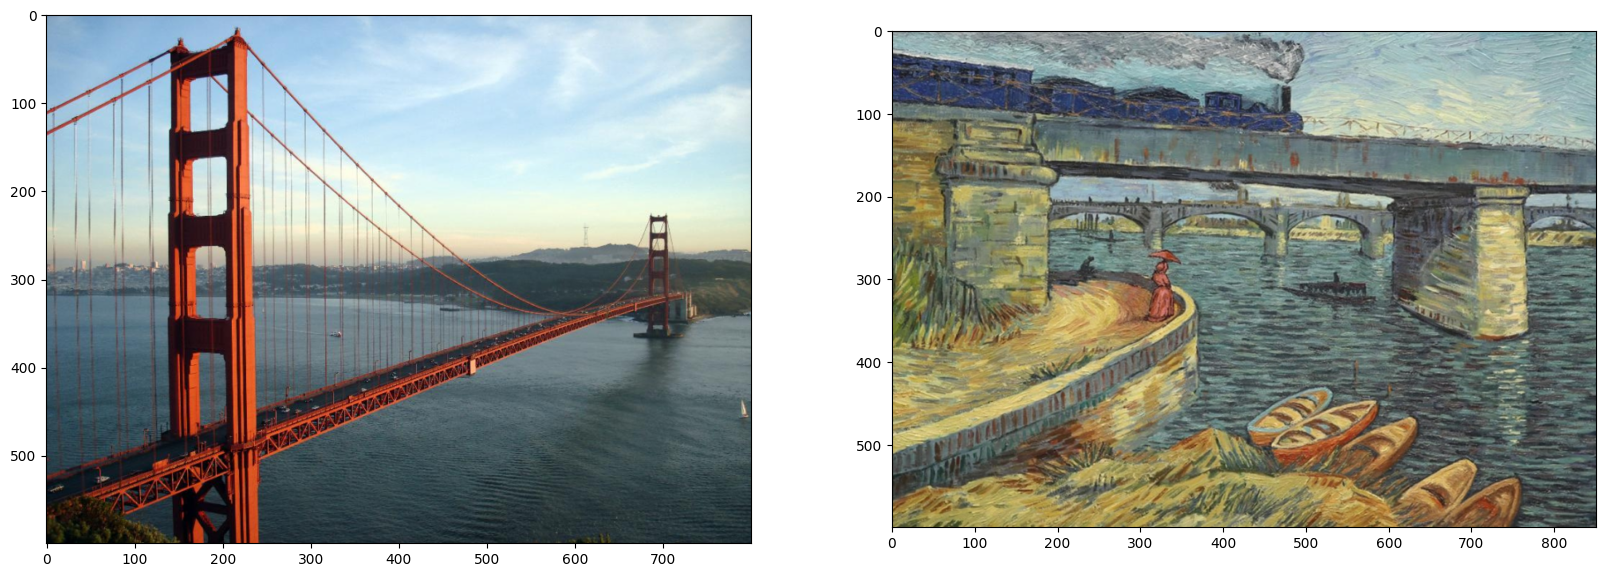

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.imshow(content_decompress)
ax2.imshow(style_decompress)

### Get Content ,style features and create gram matrix

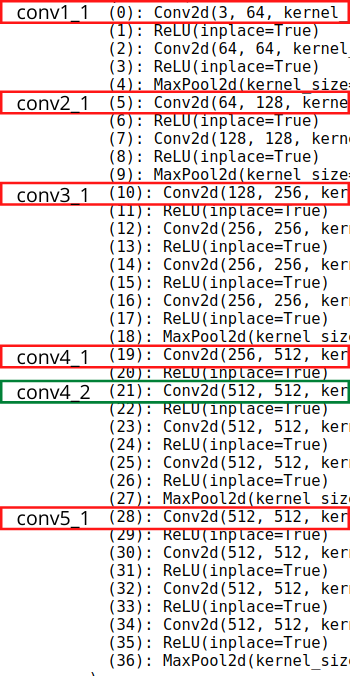

- Green  =  content features
- Red  = Style features

In [23]:
# function to extract style and features layer
def get_features(img,model):
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '28' : 'conv5_1',
      '21' : 'conv4_2', # content_feature
  }
  x = img
  features = { }
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [24]:
content_f = get_features(content_preprocess,vgg)
style_f = get_features(style_preprocess,vgg)

In [25]:
def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [26]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

## Style and Content loss

In [27]:
def content_loss(target_conv4_2,content_conv4_2):
  loss = torch.mean((target_conv4_2 -content_conv4_2)**2)
  return loss

In [28]:
style_wt = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2,
}

In [29]:
def style_loss(style_wt,target_features,style_grams):
  loss=0
  for layer in style_wt:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]

    b,c,h,w = target_f.shape
    layer_loss = style_wt[layer]*torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

In [30]:
target =  content_preprocess.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)
print("Content Loss:",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss:",style_loss(style_wt,target_f,style_grams))

Content Loss: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss: tensor(236.5972, device='cuda:0', grad_fn=<AddBackward0>)


### Training Loop

In [31]:
from torch import optim
opt = optim.Adam([target],lr=0.003)

alpha = 10
beta = 1e5
epoch = 3000
show_every = 200

In [32]:
def total_loss(c_loss,s_loss,alpha,beta):
  loss = alpha*c_loss + beta*s_loss
  return loss

In [39]:
results = []

for i in range(epoch):
  target_f = get_features(target,vgg)
  c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss = style_loss(style_wt,target_f,style_grams)
  t_loss = total_loss(c_loss,s_loss,alpha,beta)

  opt.zero_grad()
  t_loss.backward()
  opt.step()

  if i % show_every == 0 :
    print("Total loss at epoch {} : {}".format(i,t_loss))
    results.append(decompress(target.detach()))

Total loss at epoch 0 : 4558.68798828125
Total loss at epoch 200 : 4267.91650390625
Total loss at epoch 400 : 4032.898193359375
Total loss at epoch 600 : 3789.029541015625
Total loss at epoch 800 : 3594.189697265625
Total loss at epoch 1000 : 3600.670654296875
Total loss at epoch 1200 : 3244.4560546875
Total loss at epoch 1400 : 3103.304931640625
Total loss at epoch 1600 : 2960.09375
Total loss at epoch 1800 : 2851.440185546875
Total loss at epoch 2000 : 2797.05908203125
Total loss at epoch 2200 : 2716.455810546875
Total loss at epoch 2400 : 2552.577880859375
Total loss at epoch 2600 : 2488.98583984375
Total loss at epoch 2800 : 2539.57568359375


In [40]:
plt.figure(figsize = (10,8))

for i in range(len(results)):
  #plt.subplot(5,2,i+1)
  plt.imshow(results[i])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

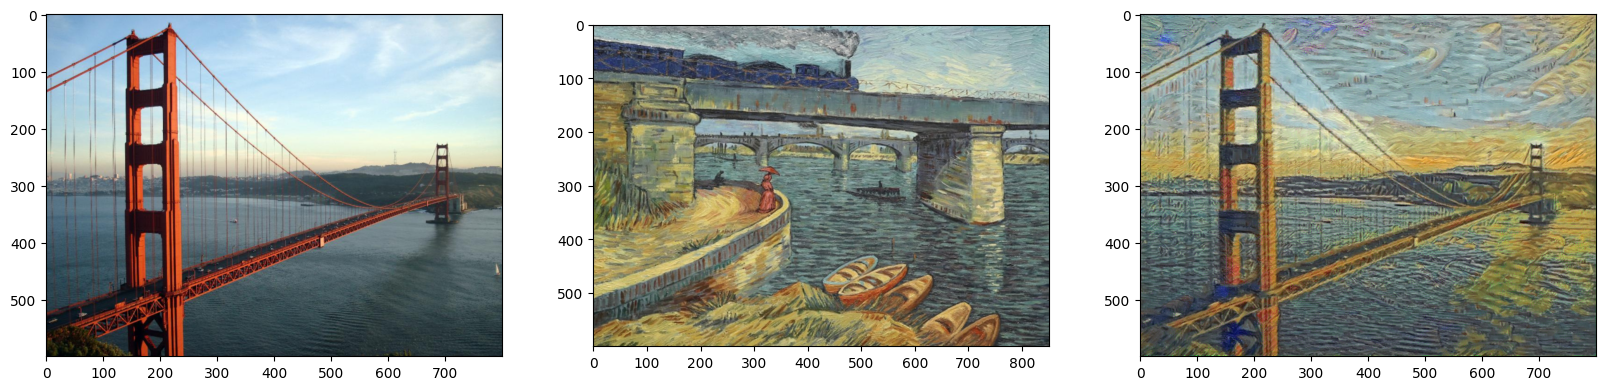

In [41]:
from mpl_toolkits.mplot3d.axes3d import axis3d
target_copy = decompress(target.detach())
content_copy = decompress(content_preprocess)
style_copy = decompress(style_preprocess)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
ax1.imshow(content_copy)
ax2.imshow(style_copy)
ax3.imshow(target_copy)

In [ ]:
save_model_path = "/content/drive/MyDrive/Opencv/Neural Style Transfer/models/Vin_Van_NST_4000_unstable_vgg19.pth"
torch.save(vgg.state_dict(), save_model_path)